## Training an image classifier

We will do the following steps in order:

1.  Load and normalize the CIFAR10 training and test datasets using
    `torchvision`
2.  Define a Convolutional Neural Network
3.  Define a loss function
4.  Train the network on the training data
5.  Test the network on the test data

### 1. Load and normalize CIFAR10

Using `torchvision`, it's extremely easy to load CIFAR10.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range \[0,
1\]. We transform them to Tensors of normalized range \[-1, 1\].

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>If you are running this tutorial on Windows or MacOS and encounter aBrokenPipeError or RuntimeError related to multiprocessing, try settingthe num_worker of torch.utils.data.DataLoader() to 0.</p>

</div>


In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

batch_size = 4
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=2
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=2
)
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

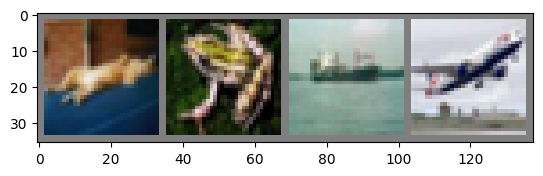

cat   frog  ship  plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(batch_size)))

### 2. Define a Convolutional Neural Network


In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

We simply loop over out data iterator, and feed the inputs to the network and optimize.


In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimze
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0

print("Finished Training")

[1,  2000] loss: 2.193
[1,  4000] loss: 1.874
[1,  6000] loss: 1.646
[1,  8000] loss: 1.562
[1, 10000] loss: 1.518
[1, 12000] loss: 1.459
[2,  2000] loss: 1.382
[2,  4000] loss: 1.371
[2,  6000] loss: 1.328
[2,  8000] loss: 1.318
[2, 10000] loss: 1.305
[2, 12000] loss: 1.275
Finished Training


In [ ]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But
we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get
familiar.


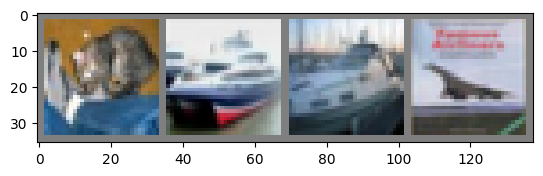

Ground Truth:  cat   ship  ship  plane


In [ ]:
data_iter = iter(test_loader)
images, labels = next(data_iter)
# print images
imshow(torchvision.utils.make_grid(images))
print("Ground Truth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [13]:
outputs = net(images)
print(outputs)

tensor([[-1.0194, -2.5321,  1.7681,  2.2901, -0.8074,  1.9501,  0.1157, -0.6569,
         -0.6061, -0.4651],
        [ 6.2605,  7.2251, -0.4392, -2.4072, -3.5528, -4.6027, -5.1196, -4.0747,
          6.3999,  5.1154],
        [ 2.8523,  4.1297, -0.0738, -1.4711, -1.7686, -2.5883, -2.5994, -1.5794,
          2.0182,  3.4900],
        [ 2.4996,  0.1565,  1.3856, -0.3069, -0.6738, -1.8675, -0.9120, -2.4319,
          3.2211,  0.5461]], grad_fn=<AddmmBackward0>)


The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let's get the index of the highest energy:


In [ ]:
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

Predicted:  cat   car   car   ship 


In [15]:
correct, total = 0, 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(
    f"Accuracy of the network on the 10000 test images: {100 * correct // total} %"
)

Accuracy of the network on the 10000 test images: 53 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {class_name: 0 for class_name in classes}
total_pred = {class_name: 0 for class_name in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for class_name, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[class_name]
    print(f"Accuracy for class: {class_name:5s} is {accuracy:.1f} %")

Accuracy for class: plane is 53.6 %
Accuracy for class: car   is 63.9 %
Accuracy for class: bird  is 58.8 %
Accuracy for class: cat   is 31.0 %
Accuracy for class: deer  is 27.5 %
Accuracy for class: dog   is 50.9 %
Accuracy for class: frog  is 70.0 %
Accuracy for class: horse is 42.4 %
Accuracy for class: ship  is 63.5 %
Accuracy for class: truck is 77.5 %


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)

cpu
